In [50]:
!pip install Groq
import numpy as np
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
import torch
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os
from groq import Groq
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# ContextualAugmentor

In [51]:
class ContextualAugmentor():
    def __init__(self, threshold=0.5, max_generated_sentence=3):
        self.threshold = threshold
        self.max_generated_sentence = max_generated_sentence
        self.api_key = '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' ##need to set this in environment variable
        self.client = client = Groq(
            api_key= self.api_key,
        )
        self.vectorizer = TfidfVectorizer()

    def extract_main_points(self, text):
        points = re.findall(r'\d+\.\s*(.+)', text)
        return points

    def generate_text(self, input_sentence):
        chat_completion = self.client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": f"Rephrase the following sentence in a different way and generate '{self.max_generated_sentence}' similar to this context : '{input_sentence}'",
                }
            ],
            model="llama3-8b-8192",
        )
        
        return self.extract_main_points(chat_completion.choices[0].message.content)

    def text_eliminate(self, input_sentence, generated_sentences):
        txt = []
        for sentence in generated_sentences:
            try:
                tfidf_matrix = self.vectorizer.fit_transform([input_sentence, sentence])
                cos_sim = cosine_similarity(tfidf_matrix[0:1], tfidf_matrix[1:2])
                if cos_sim >= self.threshold:
                    txt.append(sentence)
            except:
                continue
        return txt

    def extract_augmented_and_other_column(self, dataframe, augment_column_name):
        x = dataframe.loc[:, dataframe.columns!=augment_column_name]
        augment_column = dataframe[augment_column_name]
        return (x, augment_column)

    def augmentation(self,other_column, augment_column):
        augmented_data_list = []
        other_data_list = []
        
        for row, text in enumerate(tqdm(augment_column)):
            temparray = []
            for a in other_column:
                temparray.append(other_column[a].iloc[row])
            generated_text = self.generate_text(text)
            final_text_list = self.text_eliminate(text, generated_text)

            for s in final_text_list:
                augmented_data_list.append(s)
                other_data_list.append(temparray) 
        return augmented_data_list, other_data_list
            
    def augment(self, dataframe, augmented_column_name):
        other_col, augment_col = self.extract_augmented_and_other_column(dataframe, augmented_column_name)
        augment_data, data = self.augmentation(other_col, augment_col)
        length = len(augment_data)
        npdata = np.array(data)
        npaug = np.array(augment_data)
        print(npdata.shape, npaug.shape)
        dataframe = pd.DataFrame()
        print(data)
        count = 0
        for col_nm in other_col:
          dataframe[col_nm] = npdata[:, count].flatten()
          count += 1
        dataframe[augmented_column_name] = npaug.flatten()
        return dataframe
    
    def dataframe_to_csv(self, dataframe, path=".", filename='augmentdata.csv'):
        dataframe.to_csv(path + "/" + filename)
        return "Converted Sucessfully"
        

In [52]:
df = pd.read_csv("/kaggle/input/twitter-sentiment-analysis-data/twitter_validation.csv")
df.head()

,Tweet Id,Entity,Sentiment,Tweet Content
0,3364,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,352,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,Negative,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,Neutral,Now the President is slapping Americans in the...


In [53]:
df.shape, df.columns

((1000, 4),
 Index(['Tweet Id', 'Entity', 'Sentiment', 'Tweet Content'], dtype='object'))

In [54]:
data_cleaned = df.dropna()

## Evaluate Before augmentation

In [55]:
X = data_cleaned["Tweet Content"]
y = data_cleaned["Sentiment"]

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42, stratify=y)

# Step 2: Text Vectorization
# Converting text to a bag-of-words representation
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Step 3: Model Training
# Using a Naive Bayes classifier for sentiment classification
model = MultinomialNB()
model.fit(X_train_vec, y_train)

# Step 4: Evaluation on Test Data
y_pred = model.predict(X_test_vec)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(type(report))

<class 'str'>


In [56]:
# Print Evaluation Results
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(report)

Accuracy: 0.43125

Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.33      0.09      0.15       138
    Negative       0.48      0.43      0.45       213
     Neutral       0.43      0.52      0.47       228
    Positive       0.41      0.56      0.47       221

    accuracy                           0.43       800
   macro avg       0.41      0.40      0.39       800
weighted avg       0.42      0.43      0.41       800



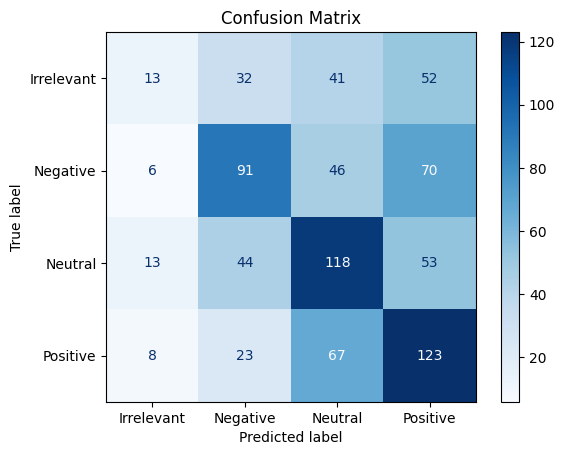

In [57]:
conf_matrix = confusion_matrix(y_test, y_pred)

# Display Confusion Matrix
ConfusionMatrixDisplay(conf_matrix, display_labels=model.classes_).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

## Evaluate after Data augmentation

In [58]:
train_df = pd.DataFrame()
train_df["Tweet Content"] = X_train
train_df["Sentiment"] = y_train

train_df.head()


,Tweet Content,Sentiment
810,I'm WHEEZING,Neutral
683,#Azure Microsoft unlocks the full potential of...,Neutral
47,You mean the same Johnson & Johnson that suppr...,Negative
901,"[Dirty-Gaming] GTA RP ! JJ on Tour, hat eine ...",Irrelevant
819,Let's all agree to completely trash the inevit...,Negative


In [59]:
# Step 1: Initialize ContextualAugmentor
augmentor = ContextualAugmentor(threshold=0.5, max_generated_sentence=3)

# Step 2: Perform Augmentation
augmented_dataframe = augmentor.augment(train_df, "Tweet Content")

100%|██████████| 200/200 [06:33<00:00,  1.97s/it]

(18, 1) (18,)
[['Negative'], ['Positive'], ['Irrelevant'], ['Irrelevant'], ['Neutral'], ['Neutral'], ['Positive'], ['Positive'], ['Neutral'], ['Negative'], ['Neutral'], ['Neutral'], ['Irrelevant'], ['Irrelevant'], ['Irrelevant'], ['Irrelevant'], ['Irrelevant'], ['Neutral']]


In [66]:
augmented_dataframe.head()

,Sentiment,Tweet Content
0,Negative,"""Thrilling news! 'Plague of Corruption' has re..."
1,Positive,"""Whoa, what a night in Red Dead Redemption! Ma..."
2,Irrelevant,"""Congratulations to the rockstar team at @EA f..."
3,Irrelevant,"""Huge congrats to the innovative minds at @Ubi..."
4,Neutral,"""I just escaped the T-Mobile store after getti..."


In [67]:
augmented_dataframe.shape

(18, 2)

In [68]:
# Step 3: Prepare Data for Training

vectorizer = CountVectorizer(stop_words='english', max_features=5000)
X_train_vec = augmented_dataframe["Tweet Content"]
X_test_vec = augmented_dataframe["Sentiment"]
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Step 4: Train Model
model = MultinomialNB()
model.fit(X_train_vec, y_train)

# Step 5: Evaluate Model
y_pred = model.predict(X_test_vec)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=False)
conf_matrix = confusion_matrix(y_test, y_pred)

In [69]:
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(report)

print("\nConfusion Matrix:")
print(conf_matrix)

Accuracy: 0.43125

Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.33      0.09      0.15       138
    Negative       0.48      0.43      0.45       213
     Neutral       0.43      0.52      0.47       228
    Positive       0.41      0.56      0.47       221

    accuracy                           0.43       800
   macro avg       0.41      0.40      0.39       800
weighted avg       0.42      0.43      0.41       800


Confusion Matrix:
[[ 13  32  41  52]
 [  6  91  46  70]
 [ 13  44 118  53]
 [  8  23  67 123]]


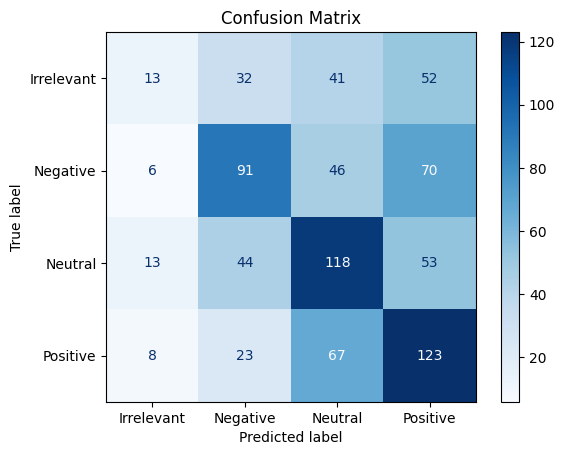

In [70]:
ConfusionMatrixDisplay(conf_matrix, display_labels=model.classes_).plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [65]:
augmented_data_folder_path = "/kaggle/input/twitter-sentiment-analysis-data"
augmentor.dataframe_to_csv(augmented_dataframe, augmented_data_folder_path,'twitter_sentiment_analysis_augment_data.csv')

OSError: [Errno 30] Read-only file system: '/kaggle/input/twitter-sentiment-analysis-data/twitter_sentiment_analysis_augment_data.csv'

## Example text generation

In [ ]:
import os
from groq import Groq

client = Groq(
    api_key= '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',
)

input_sentence = "She is very beautiful."
max_generated_text = 3

chat_completion = client.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": f"Rephrase the following sentence in a different way and generate '{max_generated_text}' similar to this context : '{input_sentence}'",
        }
    ],
    model="llama3-70b-8192",
)

print(chat_completion.choices[0].message.content)